<a href="https://colab.research.google.com/github/Pallav-Lama/deeplearning-projects/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224, 224, 3))
])
model.build([None, 224, 224, 3])

In [ ]:
!wget https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/18_transfer_learning/ImageNetLabels.txt

--2023-08-13 14:29:58--  https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/18_transfer_learning/ImageNetLabels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10484 (10K) [text/plain]
Saving to: ‘ImageNetLabels.txt.1’

ImageNetLabels.txt. 100%[===================>]  10.24K  --.-KB/s    in 0s      

2023-08-13 14:29:58 (132 MB/s) - ‘ImageNetLabels.txt.1’ saved [10484/10484]



In [ ]:
!wget https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/goldfish.jpg

--2023-08-13 14:29:58--  https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/goldfish.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7050 (6.9K) [text/plain]
Saving to: ‘goldfish.jpg.1’

goldfish.jpg.1      100%[===================>]   6.88K  --.-KB/s    in 0s      

2023-08-13 14:29:58 (65.3 MB/s) - ‘goldfish.jpg.1’ saved [7050/7050]



In [ ]:
image_labels = []
with open("ImageNetLabels.txt", 'r') as f:
  image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))
}

In [ ]:
flowers_labels_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion': 2,
    'sunflowers' : 3,
    'tulips' : 4
}

In [ ]:
X, y = [], []
for flower_name, images in flowers_images_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append(flowers_labels_dict[flower_name])
X = np.array(X)/255
y = np.array(y)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape

(2936, 224, 224, 3)

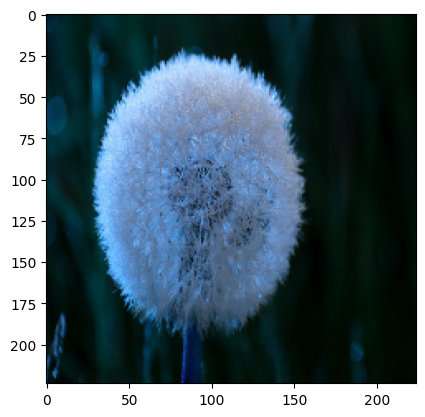

In [ ]:
plt.imshow(X_train[0])

In [ ]:
predicted = model.predict(np.array([X[0], X[1], X[2], X[3]]))
predicted = np.argmax(predicted, axis = 1)

1/1 [==============================] - 9s 9s/step


In [ ]:
predictions = []
for prediction in predicted:
  predictions.append(image_labels[prediction])

In [ ]:
predictions

['cauliflower', 'artichoke', 'coral reef', 'ant']

In [ ]:
def image_shower(index):
  print(predictions[index])
  plt.imshow(X[index], cmap = 'gray')

artichoke


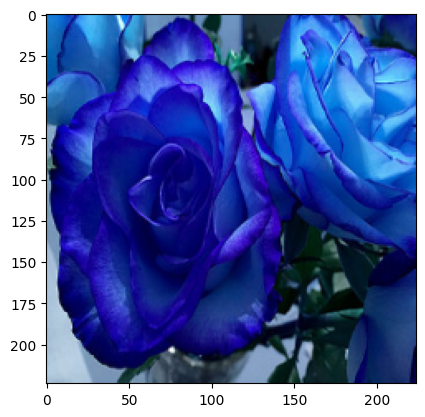

In [ ]:
image_shower(1)

coral reef


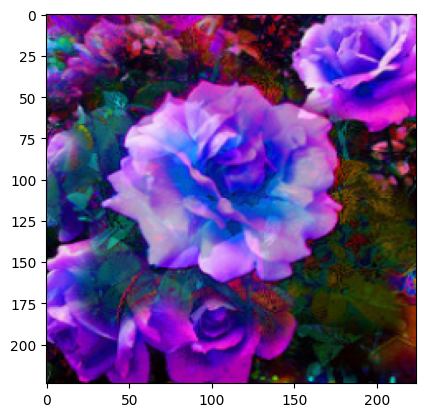

In [ ]:
image_shower(2)

In [ ]:
feature_extractor_vector = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_vector, input_shape = (224, 224, 3), trainable = False)

In [ ]:
new_model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(5)
])

new_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)
new_model.fit(X_train, y_train, epochs = 5)